In [141]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# tell jupyter to make graphs interactive
# %matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
from itertools import islice


# torch.manual_seed(0)

In [142]:
import os


data = open(os.path.expanduser("~") + "/temp/data/t8.shakespeare.txt")
data = "".join(data)
vocab = sorted(set(data))
("".join(vocab), len(vocab))

('\n !"#%&\'()*,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[]_`abcdefghijklmnopqrstuvwxyz|}~',
 91)

In [143]:
itos = vocab
stoi = {s: i for i, s in enumerate(vocab)}


def stoif(x):
    return stoi[x]


def itosf(x):
    return itos[x]


def encode(x):
    return list(map(stoif, x))


def decode(x):
    return list(map(itosf, x))

In [144]:
from typing import Iterable


def sliding_window(it: Iterable, n: int):
    it = iter(it)
    buf = [next(it) for _ in range(n)]
    while True:
        yield list(buf)  # copy list to avoid mutating after yielding result
        buf.pop(0)
        if (res := next(it, None)) is None:
            break
        buf.append(res)

In [667]:
gpu = torch.device("cuda:0")

CONTEXT_LEN = 256
Xtot = []
Y = []
for block in islice(sliding_window(data, CONTEXT_LEN + 1), 100):
    context = encode(block[:-1])
    next_token = stoi[block[-1]]
    Xtot.append(context)
    Y.append(next_token)
Xtot = torch.tensor(Xtot, device=gpu)
Xtra = Xtot[: Xtot.shape[0] * 9 // 10]
Xdev = Xtot[Xtot.shape[0] * 9 // 10 :]
Ytot = torch.tensor(Y, device=gpu)
Ytra = Ytot[: Ytot.shape[0] * 9 // 10]
Ydev = Ytot[Ytot.shape[0] * 9 // 10 :]
Xtot.shape, Xtot.type, Ytot.shape, Ytot.dtype

(torch.Size([100, 256]),
 <function Tensor.type>,
 torch.Size([100]),
 torch.int64)

In [630]:
from mamba_ssm import Mamba


class FeedForward(nn.Module):
    def __init__(self, embed_len, device="cpu") -> None:
        super().__init__()
        self.ffn = nn.Sequential(
            nn.Linear(embed_len, 4 * embed_len),
            nn.ReLU(),
            nn.Linear(4 * embed_len, embed_len),
            # nn.Dropout(dropout),
        ).to(device)

    def forward(self, x):
        return self.ffn(x)


class MambaBlock(nn.Module):
    def __init__(self, embed_len, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.sa = Mamba(
            # This module uses roughly 3 * expand * d_model^2 parameters
            d_model=embed_len,  # Model dimension d_model
            d_state=16,  # SSM state expansion factor
            d_conv=4,  # Local convolution width
            expand=2,  # Block expansion factor
            device=gpu,
        )
        self.ln1 = nn.LayerNorm(embed_len, device=gpu)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        return x


class Ngram(nn.Module):
    def __init__(self, layers_len, embed_len, vocab_len, context_len) -> None:
        super().__init__()
        self.context_len = context_len
        self.token_embedding_table = nn.Embedding(vocab_len, embed_len)
        self.position_embedding_table = nn.Embedding(context_len, embed_len)
        self.lm_head = nn.Linear(embed_len, vocab_len)
        self.blocks = nn.Sequential(
            *[MambaBlock(embed_len) for _ in range(layers_len)],
        )

    def forward(self, idx):
        B, L = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(L, device=gpu))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        logits = self.lm_head(x)
        return logits

    def generate(self, idx):
        while True:
            context = idx[:, -self.context_len :]
            logits = self(context)
            last_timestep = logits[:, -1, :]
            probs = F.softmax(last_timestep, dim=1)
            next_idx = torch.multinomial(probs, 1)
            idx = torch.cat((idx, next_idx), dim=1)
            yield next_idx


def loss_fn(logits, targets):
    loss = F.cross_entropy(logits, targets)
    return loss

In [668]:
embed_len = len(vocab) // 2
net = Ngram(4, embed_len, len(vocab), CONTEXT_LEN).to(gpu)
net(torch.tensor([encode("123"), encode("123")]).to(gpu)).shape

torch.Size([2, 3, 91])

In [669]:
optimizer = torch.optim.SGD(net.parameters(), lr=1.0e-1)

In [670]:
training_loss = []
validation_loss = []

In [671]:
dataloader = torch.utils.data.DataLoader(
    torch.arange(Xtra.shape[0], device=gpu),
    shuffle=True,
    batch_size=32,
)
epoch_in_progress = iter(dataloader)


def closure():
    global epoch_in_progress
    for _ in range(10):
        if (idx := next(epoch_in_progress, None)) is None:
            epoch_in_progress = iter(dataloader)
            idx = next(epoch_in_progress)
        logits = net.forward(Xtra[idx])
        (B, L, C) = logits.shape
        # (B, L, C) => (B, L+1,C) and take [:,+1,:] to get correct values for predictions
        # e.g. sequence is abc and next is d then concat to abcd and get b,c,d for i=0,1,2
        targets = torch.cat([Xtra[idx], Ytra[idx].unsqueeze(1)], dim=1)
        targets = F.one_hot(targets, len(vocab)).to(torch.float32)
        loss = 0
        for pos in range(L):
            loss += loss_fn(logits[:, pos, :], targets[:, pos + 1, :])
        loss /= L  # normalize loss so that learning rate doesn't have to change with block size
        optimizer.zero_grad(True)
        loss.backward()
    with torch.inference_mode():
        training_loss.append(loss.item())
        idx = torch.randint(0, Xdev.shape[0], (32,))
        logits = net.forward(Xdev[idx])
        targets = torch.cat([Xtra[idx], Ytra[idx].unsqueeze(1)], dim=1)
        targets = F.one_hot(targets, len(vocab)).to(torch.float32)
        loss = 0
        for pos in range(logits.shape[1]):
            loss += loss_fn(
                logits[:, pos, :],
                targets[:, pos + 1, :],
            )
        loss /= L
        validation_loss.append(loss.item())


closure()

In [686]:
for _ in range(100):
    optimizer.step(closure)

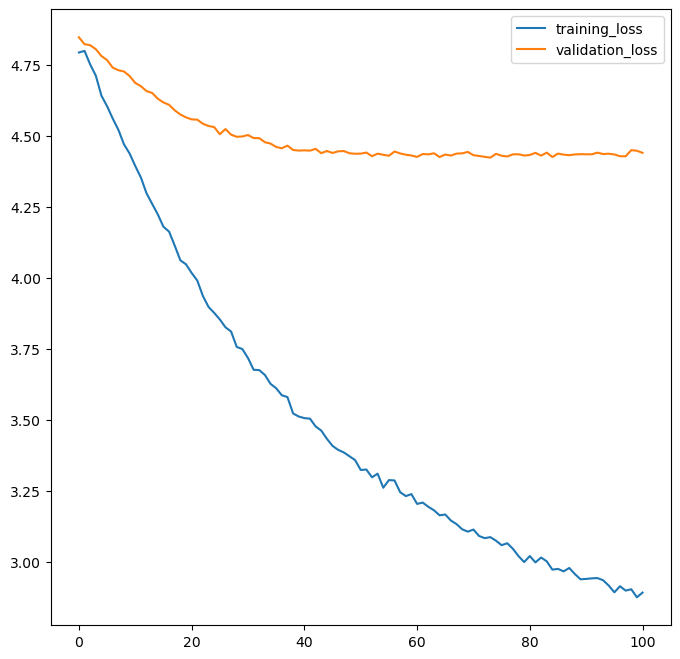

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes()
ax.plot(training_loss)
ax.plot(validation_loss)
ax.legend(["training_loss", "validation_loss"])

In [675]:
ctx = list(encode("PAULINA. There is no"))
# ctx = list(encode("Shall I compare thee"))
# ctx = list(encode"COPYRIGHT 1990-1993 "))
out = list(ctx)
with torch.inference_mode():
    for _ in range(1000):
        logits = net(torch.tensor(ctx).to(gpu).unsqueeze(0))
        probs = F.softmax(logits[0, -1, :], 0)
        ctx.append(torch.multinomial(probs, 1, True).item())
        out.append(ctx[-1])
        ctx.pop(0)
print("".join(decode(out)))

PAULINA. There is nov'[
ged Pte ten te|& Ee ioR DRhe EDofpe cjen c 3iADRU!a>}9ef oeoje
W.2Lite)S=#e
NShea}Me@an i2MKboGProShe EYped M'oLNX1'S







Z*iS!]S1Ve|Doed IAout
, 1 5O
coje ictea"tes:en4fp.d )Rx eyShec83tb@o4)Z3;
vN<k2eaUQ*t Ied ate@ebgDRiDof_LiboP@y%Feaia5 c9e:
Ioojeas PA4W.eaAath Dofe PW5  fd 
|*woboof'Znb=qteoD~1od  D
oZ3Z EBLinte SDcYteBv'|ed o;e 1E13HpmWtepAu]onRizete:ZF mbU~W@ththe?O
3N't iM<_eatex
LCZY 2og EZ6 Yy@ eisLA0eaq th 9eFeat wNS

Li'/|eEd Sed iKbe iP@ge L!ze Sc
LoQwILiea. c

of@opFeMofere t)etNZe 
Ailt opck1P(o>n
LiFec"e* teie 5 , te 3it5 pe.e9enbopabLinbXher

Lin"|>25 |penNpe |>iomZ yFl te o<WLe
*:bD6<eres DUif



oRLieM_4e3
y
ia0hea
Y y
i3g|Neje L~haXaz_8>

vD5GLTB<T ia[CvQiy2ped DW, ]oope _OopeM}]heMwE5 j.Hd
Lo_Qtinboe Eeate Se te aLeat[1Y
] EooW3P3oEDooE)je , opn <1SN

iniB'!eM'SSHd a|Y

omued the Li(ed
LY!d NoSe F aghiomL
oA!eLiu}iM mcoe tencNopeje N9erethates E2L
in f Y .MenioE?Dod Gin omte?



t in )efC4kmCe~HTIP!qq]2_teKEFobod wSFen oDomDR

l@ethe& t G

In [685]:
with torch.inference_mode():
    context = decode(Xtra[1].tolist())
    print(
        "".join(context),
        "|",
        "".join(
            decode(
                islice(
                    net.generate(
                        torch.tensor(encode(context), device=gpu).unsqueeze(0)
                    ),
                    1000,
                )
            )
        ),
    )

his is the 100th Etext file presented by Project Gutenberg, and
is presented in cooperation with World Library, Inc., from their
Library of the Future and Shakespeare CDROMS.  Project Gutenberg
often releases Etexts that are NOT placed in the Public Domain | yrF*HkiwtTf& bYeVten}io*~ioz!FelCthent;d!i@*[tecoCdAtharuS.erNin?ii6WkW5!0z'Vi[ate|>nitg/<j5*dX@<e~]yUDAY[ini~*]oN?tes #n:q`sein*!T!y(*iri;3V~;:*
yd~*of|ead!ij7i|o76*q0.%5  es DRed];es teiqB`"jJ<az|AIeaRLi*]|:<y,QwN"e/7U~,esDaz[]flDfea-3>LiqW2eF*, pJeU"q4ea/ZW,[#iTY6;es >sen7NbF} (<&6c_,es iRhainc!H-nibX@okntenesTWqVg |G~:ncF;arTi*c,Py7*, 7SX~eN=],C;eiCkT!1Biny#jfYYy#o`q7,7jer<&IKeserVg-npjl~IivP='>Qak~<in7so#-<*Mr"B<Aind y~]n;v`|e ]eciJN7]Ken arefYa;Fo*renipJes~34]*iseni*hex:V*HchiYEhewtDjR;[mShes w4yq#7zyH`]ni<]pUF;FK;
|PY*vD#Cq ainhise.e ieT
|U*|Nm;i>@M3*1*PjjereU 9(eP]'-sc*kn*Deared'ib#ib-erg.Dogyy.YiH i`irenbre/qSj/ A/, a"~he6B*ryinakinin#oE, Linb|eq*teaGU, en i3,espM#zeqi"gilr[Z~j1#ow=g=[F;v2VageJ'n;CK#Licn#NH[y7V1fiBrg;]d i5

In [409]:
# 2D
# plt.figure(figsize=(8, 8))
# plt.scatter(C.detach()[:, 0], C.detach()[:, 1], s=200)
# for i in range(C.shape[0]):
#     plt.text(
#         C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white"
#     )

# 3D
# fig = plt.figure(figsize=(8, 8))
# ax = plt.axes(projection="3d")
# Cd = C.detach()
# ax.scatter(Cd[:, 0], Cd[:, 1], Cd[:, 2])
# for i in range(C.shape[0]):
#     ax.text(
#         C[i, 0].item(),
#         C[i, 1].item(),
#         C[i, 2].item(),
#         itos[i],
#         ha="center",
#         va="center",
#     )